https://pubs.rsna.org/doi/epdf/10.1148/radiol.2015151169
https://pmc.ncbi.nlm.nih.gov/articles/PMC9374044/pdf/jnm222893.pdf

In [3]:
# Radiomics package
from radiomics import featureextractor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import xgboost as xgb
import SimpleITK as sitk
import os
import pydicom
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import ast
import torch
import torch.nn.functional as F
from skimage import transform
from segment_anything import sam_model_registry

Usare la ROC come metrica

In [4]:
shape_features = [
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_Maximum2DDiameterColumn',
    'original_shape_Maximum2DDiameterRow',
    'original_shape_Maximum2DDiameterSlice',
    'original_shape_Maximum3DDiameter',
    'original_shape_MeshVolume',
    'original_shape_MinorAxisLength',
    'original_shape_Sphericity',
    'original_shape_SurfaceArea',
    'original_shape_SurfaceVolumeRatio',
    'original_shape_VoxelVolume'
]

first_order_featues = [
    'original_firstorder_10Percentile',
    'original_firstorder_90Percentile',
    'original_firstorder_Entropy',
    'original_firstorder_InterquartileRange',
    'original_firstorder_Kurtosis',
    'original_firstorder_Maximum',
    'original_firstorder_MeanAbsoluteDeviation',
    'original_firstorder_Mean',
    'original_firstorder_Median',
    'original_firstorder_Minimum',
    'original_firstorder_Range',
    'original_firstorder_RobustMeanAbsoluteDeviation',
    'original_firstorder_RootMeanSquared',
    'original_firstorder_Skewness',
    'original_firstorder_TotalEnergy',
    'original_firstorder_Uniformity',
    'original_firstorder_Variance'
]

glcm_features = [
    'original_glcm_Autocorrelation',
    'original_glcm_ClusterProminence',
    'original_glcm_ClusterShade',
    'original_glcm_ClusterTendency',
    'original_glcm_Contrast',
    'original_glcm_Correlation',
    'original_glcm_DifferenceAverage',
    'original_glcm_DifferenceEntropy',
    'original_glcm_DifferenceVariance',
    'original_glcm_Id',
    'original_glcm_Idm',
    'original_glcm_Idmn',
    'original_glcm_Idn',
    'original_glcm_Imc1',
    'original_glcm_Imc2',
    'original_glcm_InverseVariance',
    'original_glcm_JointAverage',
    'original_glcm_JointEnergy',
    'original_glcm_JointEntropy',
    'original_glcm_MCC',
    'original_glcm_MaximumProbability',
    'original_glcm_SumAverage',
    'original_glcm_SumEntropy',
    'original_glcm_SumSquares'
]

gldm_features = [
    'original_gldm_DependenceEntropy',
    'original_gldm_DependenceNonUniformity',
    'original_gldm_DependenceNonUniformityNormalized',
    'original_gldm_DependenceVariance',
    'original_gldm_GrayLevelVariance',
    'original_gldm_HighGrayLevelEmphasis',
    'original_gldm_LargeDependenceEmphasis',
    'original_gldm_LargeDependenceHighGrayLevelEmphasis',
    'original_gldm_LargeDependenceLowGrayLevelEmphasis',
    'original_gldm_LowGrayLevelEmphasis',
    'original_gldm_SmallDependenceEmphasis',
    'original_gldm_SmallDependenceHighGrayLevelEmphasis',
    'original_gldm_SmallDependenceLowGrayLevelEmphasis'
]

glrlm_features = [
    'original_glrlm_GrayLevelNonUniformity',
    'original_glrlm_GrayLevelNonUniformityNormalized',
    'original_glrlm_GrayLevelVariance',
    'original_glrlm_HighGrayLevelRunEmphasis',
    'original_glrlm_LongRunEmphasis',
    'original_glrlm_LongRunHighGrayLevelEmphasis',
    'original_glrlm_LongRunLowGrayLevelEmphasis',
    'original_glrlm_LowGrayLevelRunEmphasis',
    'original_glrlm_RunEntropy',
    'original_glrlm_RunLengthNonUniformity',
    'original_glrlm_RunLengthNonUniformityNormalized',
    'original_glrlm_RunPercentage',
    'original_glrlm_RunVariance',
    'original_glrlm_ShortRunEmphasis',
    'original_glrlm_ShortRunHighGrayLevelEmphasis',
    'original_glrlm_ShortRunLowGrayLevelEmphasis'
]

glszm_features = [
    'original_glszm_GrayLevelNonUniformity',
    'original_glszm_GrayLevelNonUniformityNormalized',
    'original_glszm_GrayLevelVariance',
    'original_glszm_HighGrayLevelZoneEmphasis',
    'original_glszm_LargeAreaEmphasis',
    'original_glszm_LargeAreaHighGrayLevelEmphasis',
    'original_glszm_LargeAreaLowGrayLevelEmphasis',
    'original_glszm_LowGrayLevelZoneEmphasis',
    'original_glszm_SizeZoneNonUniformity',
    'original_glszm_SizeZoneNonUniformityNormalized',
    'original_glszm_SmallAreaEmphasis',
    'original_glszm_SmallAreaHighGrayLevelEmphasis',
    'original_glszm_SmallAreaLowGrayLevelEmphasis',
    'original_glszm_ZoneEntropy',
    'original_glszm_ZonePercentage',
    'original_glszm_ZoneVariance'
]

ngtdm_features = [
    'original_ngtdm_Busyness',
    'original_ngtdm_Coarseness',
    'original_ngtdm_Complexity',
    'original_ngtdm_Contrast',
    'original_ngtdm_Strength'
]

## Read a DICOM series from a directory

In [5]:
def read_dicomdir(dir_path: str) -> list:
    # opening the dicom files in the dir
    dicom_files = [
        os.path.join(dir_path, f) 
        for f in os.listdir(dir_path)
    ]
    
    # Sort the files based on slice location (for this patient is already done)
    dicom_files.sort(key=lambda x: pydicom.dcmread(x).InstanceNumber)
    
    # read the actual dicom files
    slices = [pydicom.dcmread(f) for f in dicom_files]
    
    return slices

## Reconstruct 3d shape

In [6]:
def get_3d_shape(dicom_slices: list) -> np.ndarray:
    pixel_arrays = [s.pixel_array for s in dicom_slices]

    # stack the slices to create a 3d array
    volume_3d = np.stack(pixel_arrays, axis=0)
    
    # flip the dicom on the vertical axis
    return volume_3d[:, ::-1, :]

## Plot the model classification results

In [221]:
def show_model_performances(y_test, y_predicted):
    """
    y_test: array of shape (n_samples,)
    y_predicted: array of shape(n_samples,2) with the probabilities computed with predict_prova
    """
    print(metrics.classification_report(y_test, np.argmax(y_predicted, axis=1)))

    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 
        y_predicted[:,1]
    )
    roc_auc = metrics.auc(fpr, tpr)

    metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

    cm = metrics.confusion_matrix(y_test, np.argmax(y_predicted, axis=1))
    metrics.ConfusionMatrixDisplay(cm, display_labels=["benign", "malign"]).plot()
    plt.show()

## Get 3d bounding box

In [8]:
def bbox_3D(a: np.array):
    x = np.any(a, axis=(0, 1))
    y = np.any(a, axis=(0, 2))
    z = np.any(a, axis=(1, 2))
    xmin, xmax = np.where(x)[0][[0, -1]]
    ymin, ymax = np.where(y)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    return zmin, zmax, ymin, ymax, xmin, xmax

## Read the Multiphase MRI

In [9]:
def get_multiphase_mri(dir_path: str) -> tuple:
    volume = get_3d_shape(read_dicomdir(dir_path))
    l = np.array_split(volume, 5, axis=0)
    return (*l,)

## Show rectangular patch

In [10]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=1))

# Load up lesions dataframe

In [8]:
df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv", index_col=0)

#df["z_indexes"] = df["z_indexes"].apply(ast.literal_eval)

# get pixel spacing and slice thickness for each image
df["Pixel Spacing"] = [ float(read_dicomdir(dicom_path)[0].PixelSpacing[0]) for dicom_path in df["Registered Ax T2 FSE path"] ]
df["Slice Thickness"] = [ float(read_dicomdir(dicom_path)[0].SliceThickness) for dicom_path in df["Registered Ax T2 FSE path"] ]

In [6]:
df

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-56.85,R,"[82, 83, 84, 85]","[188, 189, 190, 191, 192, 193, 194, 195, 196, ...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",4,46,17,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
12,AMBL-003,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-2.76,R,"[49, 50, 51, 52, 53, 54, 55]","[178, 179, 180, 181, 182, 183, 184, 185, 186, ...","[357, 358, 359, 360, 361, 362, 363, 364, 365, ...",7,40,21,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
18,AMBL-004,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-51.98,L,"[81, 82, 83, 84, 85]","[163, 164, 165, 166, 167, 168, 169, 170, 171, ...","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...",5,18,13,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
24,AMBL-005,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-28.46,R,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...","[194, 195, 196, 197, 198, 199, 200, 201, 202, ...","[379, 380, 381, 382, 383, 384, 385, 386, 387, ...",13,55,47,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,1.93,R,"[55, 56, 57]","[159, 160, 161, 162, 163, 164, 165, 166, 167, ...","[391, 392, 393, 394, 395, 396, 397, 398, 399, ...",3,21,10,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1180,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-48.07,R,"[81, 82]","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...","[373, 374, 375, 376, 377, 378, 379, 380, 381, ...",2,17,14,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1181,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-32.07,R,"[73, 74, 75]","[156, 157, 158, 159, 160, 161, 162, 163, 164, ...","[338, 339, 340, 341, 342, 343, 344, 345, 346, ...",3,20,12,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1188,AMBL-631,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,33.93,L,"[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...","[143, 144, 145, 146, 147, 148, 149, 150, 151, ...","[99, 100, 101, 102, 103, 104, 105, 106, 107, 1...",22,85,87,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...


In [7]:
df.to_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv")

# Preprocessing

## Robust scaling

In [7]:
robust_scaling = lambda a: (a - np.median(a.flatten()))/scipy.stats.iqr(a.flatten())

### Patient AMBL-001

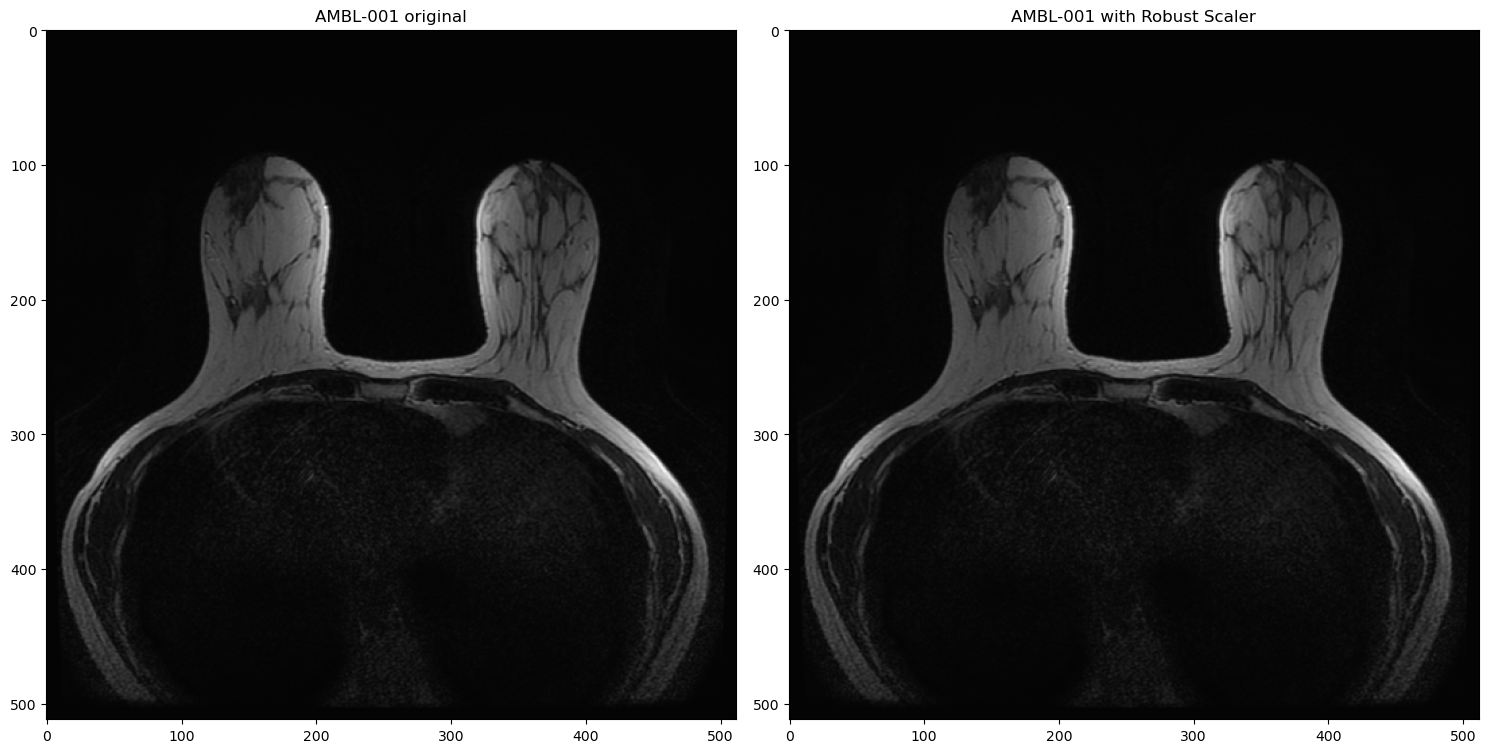

In [8]:
volume_3d = get_3d_shape(read_dicomdir(df.at[0, "Registered Ax T2 FSE path"]))
scaled_volume = robust_scaling(volume_3d)

fig, axes = plt.subplots(1, 2, figsize=(15, 15))

# First subplot
axes[0].imshow(volume_3d[83, :, :], cmap=plt.cm.gray)
axes[0].set_title('AMBL-001 original')

# Second subplot
axes[1].imshow(scaled_volume[83, :, :], cmap=plt.cm.gray)
axes[1].set_title('AMBL-001 with Robust Scaler')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

### Apply to all the patients

In [9]:
target_directory = "/media/bendico765/Crucial X9/MRI Lesions/RobustScaledMRI"
scaled_dicoms = []

try:
    os.mkdir(f"{target_directory}")
except FileExistsError:
    pass
    
for _, row in df.iterrows() :
    patient_id = row["Patient ID"]
    dicom_path = row["Registered Ax T2 FSE path"]
    filepath = f"{target_directory}/{patient_id}/Registered Ax T2 FSE/{patient_id}.npy"

    print(f"Computing patient {patient_id}")
    
    scaled_dicoms.append(filepath)

    # if doesn't exist, compute it
    if( not os.path.isfile(filepath) ):
        # create the directory for the patient mri
        try:
            os.mkdir(f"{target_directory}/{patient_id}")
            os.mkdir(f"{target_directory}/{patient_id}/Registered Ax T2 FSE")
        except FileExistsError:
            pass
        
        volume_3d = get_3d_shape(read_dicomdir(dicom_path))
        np.save(filepath, robust_scaling(volume_3d))

df["RobustScaled Registered Ax T2 FSE path"] = scaled_dicoms

Computing patient AMBL-001
Computing patient AMBL-001
Computing patient AMBL-003
Computing patient AMBL-004
Computing patient AMBL-005
Computing patient AMBL-007
Computing patient AMBL-008
Computing patient AMBL-008
Computing patient AMBL-009
Computing patient AMBL-010
Computing patient AMBL-011
Computing patient AMBL-011
Computing patient AMBL-013
Computing patient AMBL-013
Computing patient AMBL-016
Computing patient AMBL-016
Computing patient AMBL-016
Computing patient AMBL-018
Computing patient AMBL-018
Computing patient AMBL-018
Computing patient AMBL-022
Computing patient AMBL-023
Computing patient AMBL-023
Computing patient AMBL-024
Computing patient AMBL-024
Computing patient AMBL-025
Computing patient AMBL-026
Computing patient AMBL-026
Computing patient AMBL-026
Computing patient AMBL-028
Computing patient AMBL-029
Computing patient AMBL-029
Computing patient AMBL-031
Computing patient AMBL-031
Computing patient AMBL-032
Computing patient AMBL-033
Computing patient AMBL-034
C

In [10]:
df.head()

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-56.85,R,"[82, 83, 84, 85]","[188, 189, 190, 191, 192, 193, 194, 195, 196, ...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",4,46,17,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...
12,AMBL-003,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-2.76,R,"[49, 50, 51, 52, 53, 54, 55]","[178, 179, 180, 181, 182, 183, 184, 185, 186, ...","[357, 358, 359, 360, 361, 362, 363, 364, 365, ...",7,40,21,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...
18,AMBL-004,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-51.98,L,"[81, 82, 83, 84, 85]","[163, 164, 165, 166, 167, 168, 169, 170, 171, ...","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...",5,18,13,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...
24,AMBL-005,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-28.46,R,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...","[194, 195, 196, 197, 198, 199, 200, 201, 202, ...","[379, 380, 381, 382, 383, 384, 385, 386, 387, ...",13,55,47,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...


In [12]:
df.to_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv")

# Pyradiomics on robust scaled AX T2 FSE

## Create a dataset

In [11]:
df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv", index_col=0)
df

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path,Registered AX Sen Vibrant MultiPhase path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
1,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-56.85,R,"[82, 83, 84, 85]","[188, 189, 190, 191, 192, 193, 194, 195, 196, ...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",4,46,17,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
12,AMBL-003,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-2.76,R,"[49, 50, 51, 52, 53, 54, 55]","[178, 179, 180, 181, 182, 183, 184, 185, 186, ...","[357, 358, 359, 360, 361, 362, 363, 364, 365, ...",7,40,21,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
18,AMBL-004,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-51.98,L,"[81, 82, 83, 84, 85]","[163, 164, 165, 166, 167, 168, 169, 170, 171, ...","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...",5,18,13,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
24,AMBL-005,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-28.46,R,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...","[194, 195, 196, 197, 198, 199, 200, 201, 202, ...","[379, 380, 381, 382, 383, 384, 385, 386, 387, ...",13,55,47,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,1.93,R,"[55, 56, 57]","[159, 160, 161, 162, 163, 164, 165, 166, 167, ...","[391, 392, 393, 394, 395, 396, 397, 398, 399, ...",3,21,10,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
1180,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-48.07,R,"[81, 82]","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...","[373, 374, 375, 376, 377, 378, 379, 380, 381, ...",2,17,14,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
1181,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-32.07,R,"[73, 74, 75]","[156, 157, 158, 159, 160, 161, 162, 163, 164, ...","[338, 339, 340, 341, 342, 343, 344, 345, 346, ...",3,20,12,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
1188,AMBL-631,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,33.93,L,"[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...","[143, 144, 145, 146, 147, 148, 149, 150, 151, ...","[99, 100, 101, 102, 103, 104, 105, 106, 107, 1...",22,85,87,/media/bendico765/Cruci

In [277]:
features = shape_features + first_order_featues + glcm_features + gldm_features + glrlm_features + glszm_features + ngtdm_features

In [9]:
def get_radiomics_dataset(df):
    """
    Given the lesions dataframe, iterate over each lesion
    """
    for _, row in df.iterrows(): # iterate over all lesions
        patient_id = row["Patient ID"]

        # get patient data
        label = row["tumor/benign"]
        volume_3d = np.load(row["RobustScaled Registered Ax T2 FSE path"])
        pixel_spacing = row["Pixel Spacing"]
        slice_thickness = row["Slice Thickness"]
        roi = np.load(row["Cleaned Roi mask Filepath"])

        extractor = featureextractor.RadiomicsFeatureExtractor()

        # create the SITK image of the MRI
        sitk_img = sitk.GetImageFromArray(volume_3d)
        sitk_img.SetSpacing( (pixel_spacing, pixel_spacing, slice_thickness) )

        # create the SITK image of the lesion mask
        sitk_mask = sitk.GetImageFromArray(roi)
        sitk_mask.SetSpacing( (pixel_spacing,pixel_spacing, slice_thickness) )

        # extract the radiomic features
        try:
            extracted_features = extractor.execute(sitk_img, sitk_mask)
        except ValueError as e:
            print(f"[{patient_id}] Skipping error: {e}")
            continue

        # return the features plus the label and the patient id
        l = [ 
            value.item() 
            for key, value in extracted_features.items() if key in features
        ]
        l.insert(0, label)
        l.insert(0, patient_id)
        yield l

In [12]:
iterator = get_radiomics_dataset(df)
radiomics_df = pd.DataFrame(
    iterator,
    columns = ["Patient id", "tumor/benign"] + features
)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [13]:
radiomics_df

,Patient id,tumor/benign,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,AMBL-001,1.0,0.567577,0.431460,10.903997,25.272333,18.398198,27.345355,29.699455,29.785661,...,1.299532e-07,1.299532e-07,-3.203427e-16,0.000360,0.00,0.000000,1000000.000000,0.000000,0.000000e+00,0.000000
1,AMBL-001,1.0,0.395800,0.350779,9.987350,28.471925,15.595880,31.276711,31.938999,32.188502,...,1.887076e-07,1.887076e-07,-3.203427e-16,0.000434,0.00,0.000000,1000000.000000,0.000000,0.000000e+00,0.000000
2,AMBL-003,1.0,0.695898,0.424336,9.384333,22.115355,19.425872,23.607292,25.200823,27.354519,...,1.388953e-02,1.388893e-02,1.000000e+00,0.001131,770884.00,1.541565,0.163003,0.006940,2.159047e-05,0.177206
3,AMBL-004,0.0,0.762231,0.509120,6.998002,13.745296,15.791279,14.974173,13.298592,16.608017,...,1.897260e-06,1.897260e-06,-3.203427e-16,0.001377,0.00,0.000000,1000000.000000,0.000000,0.000000e+00,0.000000
4,AMBL-005,1.0,0.815240,0.652221,21.719017,33.300104,34.950107,39.333395,37.760378,43.966415,...,4.505917e-01,4.505917e-01,2.321928e+00,0.000717,17405318.29,6.901655,0.036344,0.003947,8.800251e-06,0.036169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,AMBL-629,0.0,0.783673,0.492559,6.421421,13.036854,11.250970,15.809879,14.823500,15.823010,...,1.250042e-01,1.250003e-01,1.000000e+00,0.002874,119716.00,0.354821,0.707631,0.004061,1.332917e-05,0.617716
160,AMBL-629,0.0,0.806252,0.738452,8.185088,11.084112,11.127208,12.548329,12.970312,13.334699,...,2.088276e-06,2.088276e-06,-3.203427e-16,0.001445,0.00,0.000000,1000000.000000,0.000000,0.000000e+00,0.000000
161,AMBL-629,0.0,0.804947,0.596076,6.953978,11.666268,11.560528,14.833910,13.595742,15.823010,...,2.661209e-06,2.661209e-06,-3.203427e-16,0.001631,0.00,0.000000,1000000.000000,0.000000,0.000000e+00,0.000000
162,AMBL-631,1.0,0.834795,0.686502,21.726546,31.648194,34.950107,38.778453,36.670108,39.404602,...,6.666667e-01,6.666667e-01,9.182958e-01,0.000236,35938242.00,0.492266,0.507976,0.000310,4.904832e-08,0.503957


In [14]:
radiomics_df.to_csv("/media/bendico765/Crucial X9/MRI Lesions/radiomics.csv")

## XGBoost Nested Cross-Validation on all the features

In [278]:
features = shape_features + first_order_featues + glcm_features + gldm_features + glrlm_features + glszm_features + ngtdm_features
radiomics_df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/radiomics.csv", index_col=0)
radiomics_df.info()

X = radiomics_df[features].values
y = radiomics_df["tumor/benign"].values

# Split the data in train set and hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 20, stratify = y, random_state = 0)

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 0 to 163
Columns: 107 entries, Patient id to original_ngtdm_Strength
dtypes: float64(106), object(1)
memory usage: 138.4+ KB


#### 5-FOLD WITH GRID SEARCH ####
Fold 0 - Roc Auc score 0.8571428571428571 Accuracy 0.7931034482758621
Fold 1 - Roc Auc score 0.5952380952380951 Accuracy 0.6206896551724138
Fold 2 - Roc Auc score 0.819047619047619 Accuracy 0.7241379310344828
Fold 3 - Roc Auc score 0.838095238095238 Accuracy 0.6551724137931034
Fold 4 - Roc Auc score 0.8367346938775511 Accuracy 0.75

#### HOLD-OUT TEST ####
Model #0 - Auc score: 0.8400000000000001
Model #1 - Auc score: 0.83
Model #2 - Auc score: 0.8000000000000002
Model #3 - Auc score: 0.8600000000000001
Model #4 - Auc score: 0.8400000000000001
Mean: 0.834 std: 0.01959591794226541

### AGGREGATED CLASSIFIER PERFORMANCES ###
              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84        10
         1.0       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



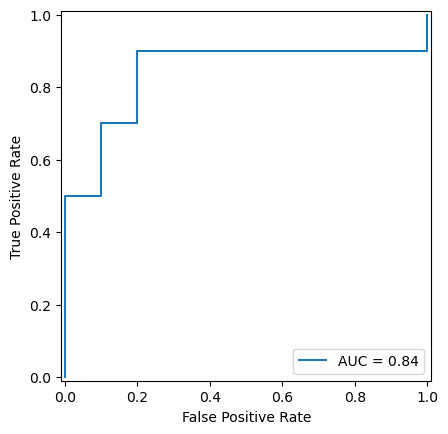

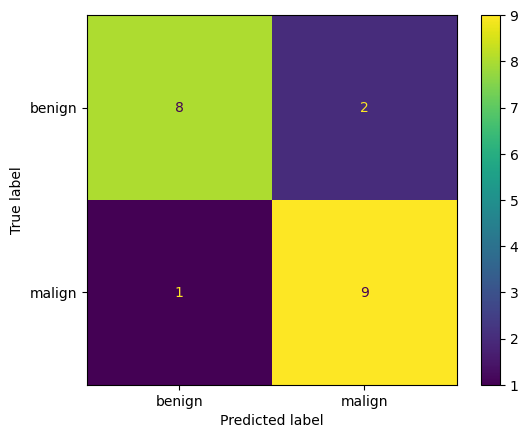

"\n# XGBoost internal representation does not have feature names\n# need to set them manually\nclf.get_booster().feature_names = features\n\nfeature_importance =clf.get_booster().get_score(importance_type='gain')\n{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}\n"

In [256]:
cv_grid = {
    "n_estimators": [10, 20, 50, 100, 200, 500],
    "max_depth": [3, 5, 10, None],
    "grow_policy": ["depthwise", "lossguide"],
}
N_OUTER_FOLDS = 5
N_INNER_FOLDS = 5
outer_fold = StratifiedKFold(n_splits=N_OUTER_FOLDS, shuffle=True, random_state=0)
clfs = []
scores = []

####### K-FOLD WITH GRID SEARCH TO GET K MODELS ######
print(f"#### {N_OUTER_FOLDS}-FOLD WITH GRID SEARCH ####")
for i, (train_index, test_index) in enumerate(outer_fold.split(X_train, y_train)): # outer fold  
    # inner fold for grid search
    grid_search = GridSearchCV(
        estimator=xgb.XGBClassifier(eval_metric=metrics.roc_auc_score),
        param_grid=cv_grid,
        cv=N_INNER_FOLDS,
        scoring="roc_auc",
        refit=True,
        verbose=0,
        n_jobs=-1
    )
    # fitting on the fold training data
    grid_search.fit(X_train[train_index], y_train[train_index])

    # getting the best estimator (already refitted on the train data)
    best_estimator = grid_search.best_estimator_
    
    # assessing the performances on the k-th fold
    y_predicted = best_estimator.predict_proba(X_train[test_index])
    auc_score = metrics.roc_auc_score(y_train[test_index], y_predicted[:,1])
    accuracy_score = metrics.accuracy_score(y_train[test_index], np.argmax(y_predicted, axis=1))
    scores.append(auc_score)
    
    print(f"Fold {i} - Roc Auc score {auc_score} Accuracy {accuracy_score}")
    clfs.append(best_estimator)

##### ESTIMATING THE AGGREGATED K MODELS PERFORMANCES ON THE HOLD-OUT #####
print(f"\n#### HOLD-OUT TEST ####")
# testing each model on hold out
y_predicted = [ clf.predict_proba(X_test) for clf in clfs ]    

# measuring the scores of the single classifiers
auc_scores = [
    metrics.roc_auc_score(y_test, y_pred[:,1])
    for y_pred in y_predicted
]
for i, auc_score in enumerate(auc_scores):
    print(f"Model #{i} - Auc score: {auc_score}")
    
aggregated_mean = np.mean(auc_scores)
aggregated_std = np.std(auc_scores)
print(f"Mean: {aggregated_mean} std: {aggregated_std}")

# computing the aggregated mean on each single prediction
aggregated_prediction = np.mean(y_predicted, axis=0)

# getting auc and confusion matrix for the overall classifier
print(f"\n### AGGREGATED CLASSIFIER PERFORMANCES ###")
show_model_performances(y_test, aggregated_prediction) 

"""
# XGBoost internal representation does not have feature names
# need to set them manually
clf.get_booster().feature_names = features

feature_importance =clf.get_booster().get_score(importance_type='gain')
{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
"""

## XGBoost Nested Cross-Validation on shape features

In [284]:
features = shape_features

radiomics_df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/radiomics.csv", index_col=0)
radiomics_df.info()

X = radiomics_df[features].values
y = radiomics_df["tumor/benign"].values

# take 20 samples (10 benign and 10 tumor) as a final test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 20, stratify = y, random_state = 0)

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 0 to 163
Columns: 107 entries, Patient id to original_ngtdm_Strength
dtypes: float64(106), object(1)
memory usage: 138.4+ KB


#### 5-FOLD WITH GRID SEARCH ####
Fold 0 - Roc Auc score 0.7 Accuracy 0.6206896551724138
Fold 1 - Roc Auc score 0.6523809523809524 Accuracy 0.6206896551724138
Fold 2 - Roc Auc score 0.6714285714285715 Accuracy 0.6551724137931034
Fold 3 - Roc Auc score 0.7095238095238096 Accuracy 0.5862068965517241
Fold 4 - Roc Auc score 0.6887755102040816 Accuracy 0.5357142857142857

#### HOLD-OUT TEST ####
Model #0 - Auc score: 0.8200000000000001
Model #1 - Auc score: 0.8300000000000001
Model #2 - Auc score: 0.805
Model #3 - Auc score: 0.75
Model #4 - Auc score: 0.83
Mean: 0.807 std: 0.029933259094191537

### AGGREGATED CLASSIFIER PERFORMANCES ###
              precision    recall  f1-score   support

         0.0       0.67      0.80      0.73        10
         1.0       0.75      0.60      0.67        10

    accuracy                           0.70        20
   macro avg       0.71      0.70      0.70        20
weighted avg       0.71      0.70      0.70        20



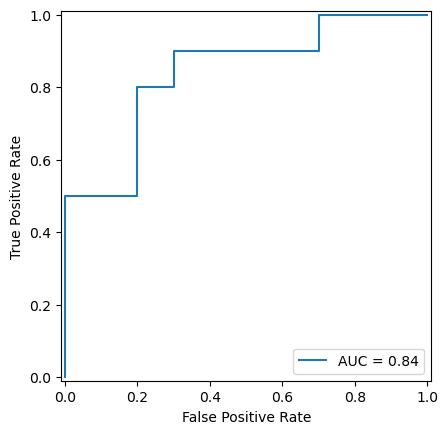

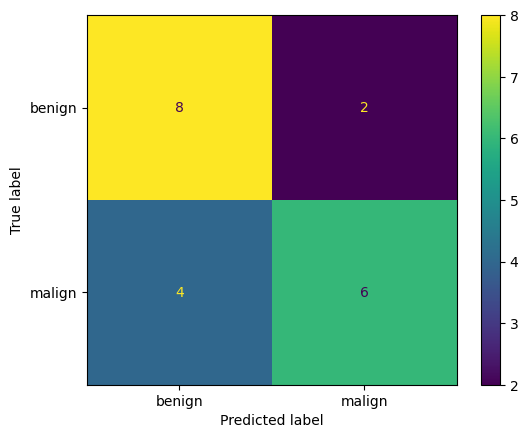

"\n# XGBoost internal representation does not have feature names\n# need to set them manually\nclf.get_booster().feature_names = features\n\nfeature_importance =clf.get_booster().get_score(importance_type='gain')\n{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}\n"

In [285]:
cv_grid = {
    "n_estimators": [10, 20, 50, 100, 200, 500],
    "max_depth": [3, 5, 10, None],
    "grow_policy": ["depthwise", "lossguide"],
}
N_OUTER_FOLDS = 5
N_INNER_FOLDS = 5
outer_fold = StratifiedKFold(n_splits=N_OUTER_FOLDS, shuffle=True, random_state=0)
clfs = []
scores = []

####### K-FOLD WITH GRID SEARCH TO GET K MODELS ######
print(f"#### {N_OUTER_FOLDS}-FOLD WITH GRID SEARCH ####")
for i, (train_index, test_index) in enumerate(outer_fold.split(X_train, y_train)): # outer fold  
    # inner fold for grid search
    grid_search = GridSearchCV(
        estimator=xgb.XGBClassifier(eval_metric=metrics.roc_auc_score),
        param_grid=cv_grid,
        cv=N_INNER_FOLDS,
        scoring="roc_auc",
        refit=True,
        verbose=0,
        n_jobs=-1
    )
    # fitting on the fold training data
    grid_search.fit(X_train[train_index], y_train[train_index])

    # getting the best estimator (already refitted on the train data)
    best_estimator = grid_search.best_estimator_
    
    # assessing the performances on the k-th fold
    y_predicted = best_estimator.predict_proba(X_train[test_index])
    auc_score = metrics.roc_auc_score(y_train[test_index], y_predicted[:,1])
    accuracy_score = metrics.accuracy_score(y_train[test_index], np.argmax(y_predicted, axis=1))
    scores.append(auc_score)
    
    print(f"Fold {i} - Roc Auc score {auc_score} Accuracy {accuracy_score}")
    clfs.append(best_estimator)

##### ESTIMATING THE AGGREGATED K MODELS PERFORMANCES ON THE HOLD-OUT #####
print(f"\n#### HOLD-OUT TEST ####")
# testing each model on hold out
y_predicted = [ clf.predict_proba(X_test) for clf in clfs ]    

# measuring the scores of the single classifiers
auc_scores = [
    metrics.roc_auc_score(y_test, y_pred[:,1])
    for y_pred in y_predicted
]
for i, auc_score in enumerate(auc_scores):
    print(f"Model #{i} - Auc score: {auc_score}")
    
aggregated_mean = np.mean(auc_scores)
aggregated_std = np.std(auc_scores)
print(f"Mean: {aggregated_mean} std: {aggregated_std}")

# computing the aggregated mean on each single prediction
aggregated_prediction = np.mean(y_predicted, axis=0)

# getting auc and confusion matrix for the overall classifier
print(f"\n### AGGREGATED CLASSIFIER PERFORMANCES ###")
show_model_performances(y_test, aggregated_prediction) 

"""
# XGBoost internal representation does not have feature names
# need to set them manually
clf.get_booster().feature_names = features

feature_importance =clf.get_booster().get_score(importance_type='gain')
{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
"""

# Pyradiomics on Multiphase - AX T2 FSE (Phase 2)

Prima di eseguire queste celle assicurarsi che siano state eseguite le celle "Load up lesions dataframe", o almeno che sul file lesions_df.csv siano presenti i campi PixelSpacing e SliceThickness.
Assicurarsi inoltre di aver eseguito il Notebook Histograms, o almeno di aver eseguito il codice che associa a ogni lesione il suo file Multiphase associato

Notare come in questa parte di esperimento non venga effettuato l'operazione di robust scaling sulle immagini

## Create the radiomics dataset

In [48]:
df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv", index_col=0)
df

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path,Registered AX Sen Vibrant MultiPhase path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
1,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-56.85,R,"[82, 83, 84, 85]","[188, 189, 190, 191, 192, 193, 194, 195, 196, ...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",4,46,17,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
12,AMBL-003,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-2.76,R,"[49, 50, 51, 52, 53, 54, 55]","[178, 179, 180, 181, 182, 183, 184, 185, 186, ...","[357, 358, 359, 360, 361, 362, 363, 364, 365, ...",7,40,21,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
18,AMBL-004,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-51.98,L,"[81, 82, 83, 84, 85]","[163, 164, 165, 166, 167, 168, 169, 170, 171, ...","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...",5,18,13,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
24,AMBL-005,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-28.46,R,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...","[194, 195, 196, 197, 198, 199, 200, 201, 202, ...","[379, 380, 381, 382, 383, 384, 385, 386, 387, ...",13,55,47,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,1.93,R,"[55, 56, 57]","[159, 160, 161, 162, 163, 164, 165, 166, 167, ...","[391, 392, 393, 394, 395, 396, 397, 398, 399, ...",3,21,10,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
1180,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-48.07,R,"[81, 82]","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...","[373, 374, 375, 376, 377, 378, 379, 380, 381, ...",2,17,14,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
1181,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-32.07,R,"[73, 74, 75]","[156, 157, 158, 159, 160, 161, 162, 163, 164, ...","[338, 339, 340, 341, 342, 343, 344, 345, 346, ...",3,20,12,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
1188,AMBL-631,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,33.93,L,"[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...","[143, 144, 145, 146, 147, 148, 149, 150, 151, ...","[99, 100, 101, 102, 103, 104, 105, 106, 107, 1...",22,85,87,/media/bendico765/Cruci

In [49]:
features = shape_features + first_order_featues + glcm_features + gldm_features + glrlm_features + glszm_features + ngtdm_features

In [50]:
def get_multiphase_radiomics_dataset(df):
    for _, row in df.iterrows(): # iterate over all lesions
        patient_id = row["Patient ID"]

        # get patient data
        label = row["tumor/benign"]
        t2_fse_volume = get_3d_shape(read_dicomdir(row["Registered Ax T2 FSE path"]))
        multiphase_volume = get_multiphase_mri(row["Registered AX Sen Vibrant MultiPhase path"])[1] # HERE SELECT ONLY THE FIRST PHASE
        pixel_spacing = row["Pixel Spacing"]
        slice_thickness = row["Slice Thickness"]
        roi = np.load(row["Cleaned Roi mask Filepath"])

        # subtract the t2 fse from the multiphase
        volume_3d = multiphase_volume - t2_fse_volume
        
        extractor = featureextractor.RadiomicsFeatureExtractor()

        # create the SITK image of the MRI
        sitk_img = sitk.GetImageFromArray(volume_3d)
        sitk_img.SetSpacing( (pixel_spacing, pixel_spacing, slice_thickness) )

        # create the SITK image of the lesion mask
        sitk_mask = sitk.GetImageFromArray(roi)
        sitk_mask.SetSpacing( (pixel_spacing,pixel_spacing, slice_thickness) )

        # extract the radiomic features
        try:
            extracted_features = extractor.execute(sitk_img, sitk_mask)
        except ValueError as e:
            print(f"[{patient_id}] Skipping error: {e}")
            continue

        # return the features plus the label and the patient id
        l = [ 
            value.item() 
            for key, value in extracted_features.items() if key in features
        ]
        l.insert(0, label)
        l.insert(0, patient_id)
        yield l

In [51]:
iterator = get_multiphase_radiomics_dataset(df)
multiphase_radiomics_df = pd.DataFrame(
    iterator,
    columns = ["Patient id", "tumor/benign"] + features
)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [52]:
multiphase_radiomics_df.to_csv("/media/bendico765/Crucial X9/MRI Lesions/phase_2_subtracted_volumes_radiomics.csv")

## XGBoost Nested Cross-Validation on all the features

In [288]:
features = shape_features + first_order_featues + glcm_features + gldm_features + glrlm_features + glszm_features + ngtdm_features

multiphase_radiomics_df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/phase_2_subtracted_volumes_radiomics.csv", index_col=0)
multiphase_radiomics_df.info()

X = multiphase_radiomics_df[features].values
y = multiphase_radiomics_df["tumor/benign"].values

# take 20 samples (10 benign and 10 tumor) as a final test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 20, stratify = y, random_state = 0)

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 0 to 163
Columns: 107 entries, Patient id to original_ngtdm_Strength
dtypes: float64(106), object(1)
memory usage: 138.4+ KB


#### 5-FOLD WITH GRID SEARCH ####
Fold 0 - Roc Auc score 0.8571428571428571 Accuracy 0.7241379310344828
Fold 1 - Roc Auc score 0.7238095238095238 Accuracy 0.6206896551724138
Fold 2 - Roc Auc score 0.8571428571428571 Accuracy 0.7241379310344828
Fold 3 - Roc Auc score 0.7714285714285715 Accuracy 0.7241379310344828
Fold 4 - Roc Auc score 0.836734693877551 Accuracy 0.75

#### HOLD-OUT TEST ####
Model #0 - Auc score: 0.88
Model #1 - Auc score: 0.8500000000000001
Model #2 - Auc score: 0.9000000000000001
Model #3 - Auc score: 0.8200000000000001
Model #4 - Auc score: 0.8900000000000001
Mean: 0.868 std: 0.029257477676655604

### AGGREGATED CLASSIFIER PERFORMANCES ###
              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84        10
         1.0       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



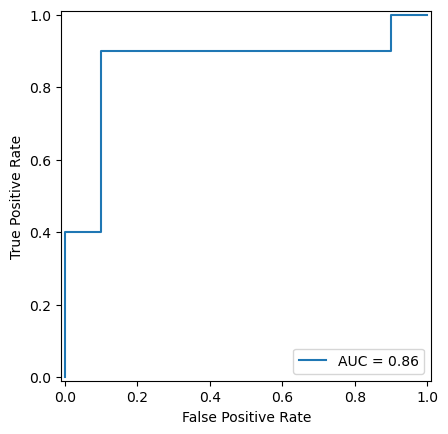

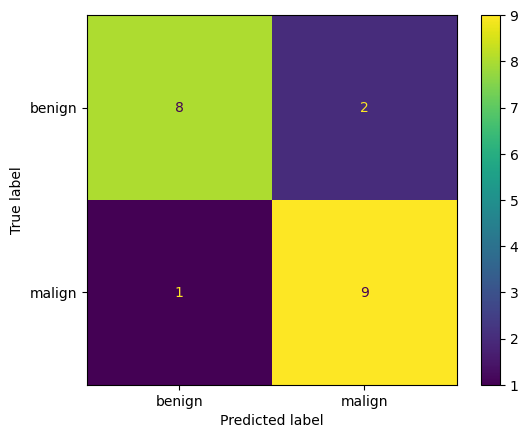

"\n# XGBoost internal representation does not have feature names\n# need to set them manually\nclf.get_booster().feature_names = features\n\nfeature_importance =clf.get_booster().get_score(importance_type='gain')\n{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}\n"

In [289]:
cv_grid = {
    "n_estimators": [10, 20, 50, 100, 200, 500],
    "max_depth": [3, 5, 10, None],
    "grow_policy": ["depthwise", "lossguide"],
}
N_OUTER_FOLDS = 5
N_INNER_FOLDS = 5
outer_fold = StratifiedKFold(n_splits=N_OUTER_FOLDS, shuffle=True, random_state=0)
clfs = []
scores = []

####### K-FOLD WITH GRID SEARCH TO GET K MODELS ######
print(f"#### {N_OUTER_FOLDS}-FOLD WITH GRID SEARCH ####")
for i, (train_index, test_index) in enumerate(outer_fold.split(X_train, y_train)): # outer fold  
    # inner fold for grid search
    grid_search = GridSearchCV(
        estimator=xgb.XGBClassifier(eval_metric=metrics.roc_auc_score),
        param_grid=cv_grid,
        cv=N_INNER_FOLDS,
        scoring="roc_auc",
        refit=True,
        verbose=0,
        n_jobs=-1
    )
    # fitting on the fold training data
    grid_search.fit(X_train[train_index], y_train[train_index])

    # getting the best estimator (already refitted on the train data)
    best_estimator = grid_search.best_estimator_
    
    # assessing the performances on the k-th fold
    y_predicted = best_estimator.predict_proba(X_train[test_index])
    auc_score = metrics.roc_auc_score(y_train[test_index], y_predicted[:,1])
    accuracy_score = metrics.accuracy_score(y_train[test_index], np.argmax(y_predicted, axis=1))
    scores.append(auc_score)
    
    print(f"Fold {i} - Roc Auc score {auc_score} Accuracy {accuracy_score}")
    clfs.append(best_estimator)

##### ESTIMATING THE AGGREGATED K MODELS PERFORMANCES ON THE HOLD-OUT #####
print(f"\n#### HOLD-OUT TEST ####")
# testing each model on hold out
y_predicted = [ clf.predict_proba(X_test) for clf in clfs ]    

# measuring the scores of the single classifiers
auc_scores = [
    metrics.roc_auc_score(y_test, y_pred[:,1])
    for y_pred in y_predicted
]
for i, auc_score in enumerate(auc_scores):
    print(f"Model #{i} - Auc score: {auc_score}")
    
aggregated_mean = np.mean(auc_scores)
aggregated_std = np.std(auc_scores)
print(f"Mean: {aggregated_mean} std: {aggregated_std}")

# computing the aggregated mean on each single prediction
aggregated_prediction = np.mean(y_predicted, axis=0)

# getting auc and confusion matrix for the overall classifier
print(f"\n### AGGREGATED CLASSIFIER PERFORMANCES ###")
show_model_performances(y_test, aggregated_prediction) 

"""
# XGBoost internal representation does not have feature names
# need to set them manually
clf.get_booster().feature_names = features

feature_importance =clf.get_booster().get_score(importance_type='gain')
{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
"""

## XGBoost Nested Cross-Validation on shape features

In [296]:
features = shape_features

multiphase_radiomics_df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/phase_2_subtracted_volumes_radiomics.csv", index_col=0)
multiphase_radiomics_df.info()

X = multiphase_radiomics_df[features].values
y = multiphase_radiomics_df["tumor/benign"].values

# take 20 samples (10 benign and 10 tumor) as a final test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 20, stratify = y, random_state = 0)

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 0 to 163
Columns: 107 entries, Patient id to original_ngtdm_Strength
dtypes: float64(106), object(1)
memory usage: 138.4+ KB


#### 5-FOLD WITH GRID SEARCH ####
Fold 0 - Roc Auc score 0.7 Accuracy 0.6206896551724138
Fold 1 - Roc Auc score 0.6523809523809524 Accuracy 0.6206896551724138
Fold 2 - Roc Auc score 0.6714285714285715 Accuracy 0.6551724137931034
Fold 3 - Roc Auc score 0.7095238095238096 Accuracy 0.5862068965517241
Fold 4 - Roc Auc score 0.6887755102040816 Accuracy 0.5357142857142857

#### HOLD-OUT TEST ####
Model #0 - Auc score: 0.8200000000000001
Model #1 - Auc score: 0.8300000000000001
Model #2 - Auc score: 0.805
Model #3 - Auc score: 0.75
Model #4 - Auc score: 0.83
Mean: 0.807 std: 0.029933259094191537

### AGGREGATED CLASSIFIER PERFORMANCES ###
              precision    recall  f1-score   support

         0.0       0.67      0.80      0.73        10
         1.0       0.75      0.60      0.67        10

    accuracy                           0.70        20
   macro avg       0.71      0.70      0.70        20
weighted avg       0.71      0.70      0.70        20



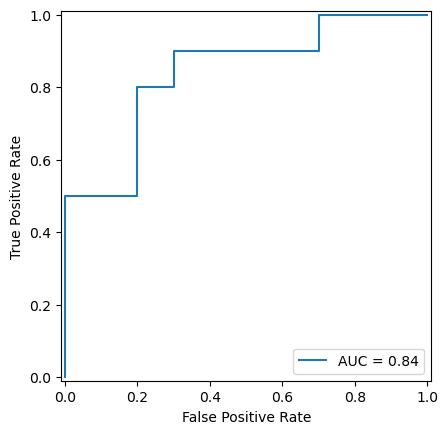

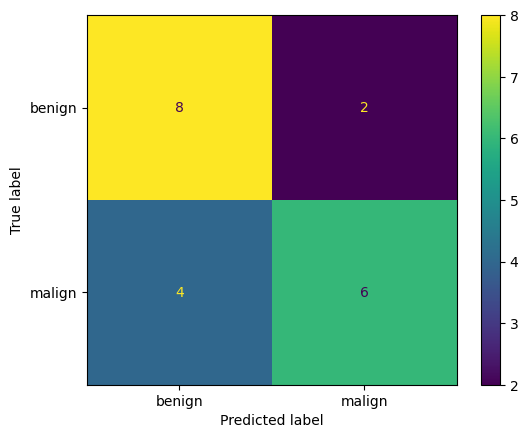

"\n# XGBoost internal representation does not have feature names\n# need to set them manually\nclf.get_booster().feature_names = features\n\nfeature_importance =clf.get_booster().get_score(importance_type='gain')\n{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}\n"

In [297]:
cv_grid = {
    "n_estimators": [10, 20, 50, 100, 200, 500],
    "max_depth": [3, 5, 10, None],
    "grow_policy": ["depthwise", "lossguide"],
}
N_OUTER_FOLDS = 5
N_INNER_FOLDS = 5
outer_fold = StratifiedKFold(n_splits=N_OUTER_FOLDS, shuffle=True, random_state=0)
clfs = []
scores = []

####### K-FOLD WITH GRID SEARCH TO GET K MODELS ######
print(f"#### {N_OUTER_FOLDS}-FOLD WITH GRID SEARCH ####")
for i, (train_index, test_index) in enumerate(outer_fold.split(X_train, y_train)): # outer fold  
    # inner fold for grid search
    grid_search = GridSearchCV(
        estimator=xgb.XGBClassifier(eval_metric=metrics.roc_auc_score),
        param_grid=cv_grid,
        cv=N_INNER_FOLDS,
        scoring="roc_auc",
        refit=True,
        verbose=0,
        n_jobs=-1
    )
    # fitting on the fold training data
    grid_search.fit(X_train[train_index], y_train[train_index])

    # getting the best estimator (already refitted on the train data)
    best_estimator = grid_search.best_estimator_
    
    # assessing the performances on the k-th fold
    y_predicted = best_estimator.predict_proba(X_train[test_index])
    auc_score = metrics.roc_auc_score(y_train[test_index], y_predicted[:,1])
    accuracy_score = metrics.accuracy_score(y_train[test_index], np.argmax(y_predicted, axis=1))
    scores.append(auc_score)
    
    print(f"Fold {i} - Roc Auc score {auc_score} Accuracy {accuracy_score}")
    clfs.append(best_estimator)

##### ESTIMATING THE AGGREGATED K MODELS PERFORMANCES ON THE HOLD-OUT #####
print(f"\n#### HOLD-OUT TEST ####")
# testing each model on hold out
y_predicted = [ clf.predict_proba(X_test) for clf in clfs ]    

# measuring the scores of the single classifiers
auc_scores = [
    metrics.roc_auc_score(y_test, y_pred[:,1])
    for y_pred in y_predicted
]
for i, auc_score in enumerate(auc_scores):
    print(f"Model #{i} - Auc score: {auc_score}")
    
aggregated_mean = np.mean(auc_scores)
aggregated_std = np.std(auc_scores)
print(f"Mean: {aggregated_mean} std: {aggregated_std}")

# computing the aggregated mean on each single prediction
aggregated_prediction = np.mean(y_predicted, axis=0)

# getting auc and confusion matrix for the overall classifier
print(f"\n### AGGREGATED CLASSIFIER PERFORMANCES ###")
show_model_performances(y_test, aggregated_prediction) 

"""
# XGBoost internal representation does not have feature names
# need to set them manually
clf.get_booster().feature_names = features

feature_importance =clf.get_booster().get_score(importance_type='gain')
{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
"""

# Pyradiomics on Multiphase - AX T2 FSE (Phase 3)

Prima di eseguire queste celle assicurarsi che siano state eseguite le celle "Load up lesions dataframe", o almeno che sul file lesions_df.csv siano presenti i campi PixelSpacing e SliceThickness.
Assicurarsi inoltre di aver eseguito il Notebook Histograms, o almeno di aver eseguito il codice che associa a ogni lesione il suo file Multiphase associato

Notare come in questa parte di esperimento non venga effettuato l'operazione di robust scaling sulle immagini

## Create the radiomics dataset

In [27]:
df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv", index_col=0)
df

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path,Registered AX Sen Vibrant MultiPhase path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
1,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-56.85,R,"[82, 83, 84, 85]","[188, 189, 190, 191, 192, 193, 194, 195, 196, ...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",4,46,17,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
12,AMBL-003,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-2.76,R,"[49, 50, 51, 52, 53, 54, 55]","[178, 179, 180, 181, 182, 183, 184, 185, 186, ...","[357, 358, 359, 360, 361, 362, 363, 364, 365, ...",7,40,21,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
18,AMBL-004,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-51.98,L,"[81, 82, 83, 84, 85]","[163, 164, 165, 166, 167, 168, 169, 170, 171, ...","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...",5,18,13,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
24,AMBL-005,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-28.46,R,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...","[194, 195, 196, 197, 198, 199, 200, 201, 202, ...","[379, 380, 381, 382, 383, 384, 385, 386, 387, ...",13,55,47,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,1.93,R,"[55, 56, 57]","[159, 160, 161, 162, 163, 164, 165, 166, 167, ...","[391, 392, 393, 394, 395, 396, 397, 398, 399, ...",3,21,10,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
1180,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-48.07,R,"[81, 82]","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...","[373, 374, 375, 376, 377, 378, 379, 380, 381, ...",2,17,14,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
1181,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-32.07,R,"[73, 74, 75]","[156, 157, 158, 159, 160, 161, 162, 163, 164, ...","[338, 339, 340, 341, 342, 343, 344, 345, 346, ...",3,20,12,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...
1188,AMBL-631,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,33.93,L,"[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...","[143, 144, 145, 146, 147, 148, 149, 150, 151, ...","[99, 100, 101, 102, 103, 104, 105, 106, 107, 1...",22,85,87,/media/bendico765/Cruci

In [28]:
features = shape_features + first_order_featues + glcm_features + gldm_features + glrlm_features + glszm_features + ngtdm_features

In [29]:
def get_multiphase_radiomics_dataset(df):
    for _, row in df.iterrows(): # iterate over all lesions
        patient_id = row["Patient ID"]

        # get patient data
        label = row["tumor/benign"]
        t2_fse_volume = get_3d_shape(read_dicomdir(row["Registered Ax T2 FSE path"]))
        multiphase_volume = get_multiphase_mri(row["Registered AX Sen Vibrant MultiPhase path"])[2] # HERE SELECT THE PHASE
        pixel_spacing = row["Pixel Spacing"]
        slice_thickness = row["Slice Thickness"]
        roi = np.load(row["Cleaned Roi mask Filepath"])

        # subtract the t2 fse from the multiphase
        volume_3d = multiphase_volume - t2_fse_volume
        
        extractor = featureextractor.RadiomicsFeatureExtractor()

        # create the SITK image of the MRI
        sitk_img = sitk.GetImageFromArray(volume_3d)
        sitk_img.SetSpacing( (pixel_spacing, pixel_spacing, slice_thickness) )

        # create the SITK image of the lesion mask
        sitk_mask = sitk.GetImageFromArray(roi)
        sitk_mask.SetSpacing( (pixel_spacing,pixel_spacing, slice_thickness) )

        # extract the radiomic features
        try:
            extracted_features = extractor.execute(sitk_img, sitk_mask)
        except ValueError as e:
            print(f"[{patient_id}] Skipping error: {e}")
            continue

        # return the features plus the label and the patient id
        l = [ 
            value.item() 
            for key, value in extracted_features.items() if key in features
        ]
        l.insert(0, label)
        l.insert(0, patient_id)
        yield l

In [30]:
iterator = get_multiphase_radiomics_dataset(df)
multiphase_radiomics_df = pd.DataFrame(
    iterator,
    columns = ["Patient id", "tumor/benign"] + features
)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


KeyboardInterrupt: 

In [ ]:
multiphase_radiomics_df

In [ ]:
multiphase_radiomics_df.to_csv("/media/bendico765/Crucial X9/MRI Lesions/phase_3_subtracted_volumes_radiomics.csv")

## XGBoost Nested Cross-Validation on all the features

In [290]:
features = shape_features + first_order_featues

multiphase_radiomics_df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/phase_3_subtracted_volumes_radiomics.csv", index_col=0)
multiphase_radiomics_df.info()

X = multiphase_radiomics_df[features].values
y = multiphase_radiomics_df["tumor/benign"].values

# take 20 samples (10 benign and 10 tumor) as a final test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 20, stratify = y, random_state = 0)

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 0 to 163
Columns: 107 entries, Patient id to original_ngtdm_Strength
dtypes: float64(106), object(1)
memory usage: 138.4+ KB


#### 5-FOLD WITH GRID SEARCH ####
Fold 0 - Roc Auc score 0.7476190476190476 Accuracy 0.6896551724137931
Fold 1 - Roc Auc score 0.6714285714285715 Accuracy 0.5862068965517241
Fold 2 - Roc Auc score 0.7 Accuracy 0.6896551724137931
Fold 3 - Roc Auc score 0.7904761904761904 Accuracy 0.6551724137931034
Fold 4 - Roc Auc score 0.7091836734693877 Accuracy 0.5714285714285714

#### HOLD-OUT TEST ####
Model #0 - Auc score: 0.8400000000000001
Model #1 - Auc score: 0.8700000000000001
Model #2 - Auc score: 0.8400000000000001
Model #3 - Auc score: 0.8799999999999999
Model #4 - Auc score: 0.87
Mean: 0.86 std: 0.01673320053068146

### AGGREGATED CLASSIFIER PERFORMANCES ###
              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84        10
         1.0       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



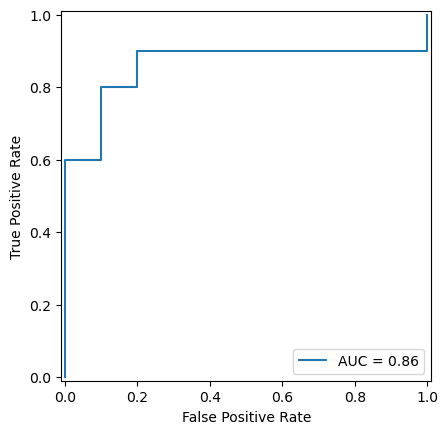

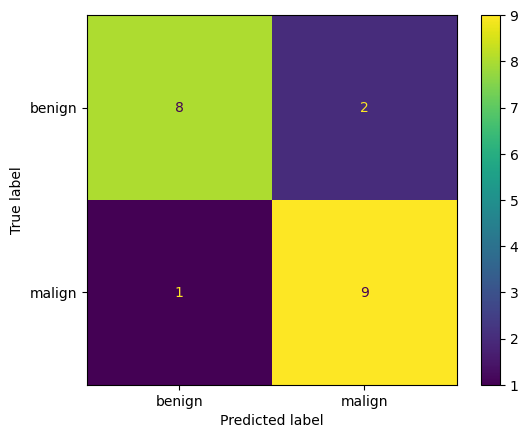

"\n# XGBoost internal representation does not have feature names\n# need to set them manually\nclf.get_booster().feature_names = features\n\nfeature_importance =clf.get_booster().get_score(importance_type='gain')\n{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}\n"

In [291]:
cv_grid = {
    "n_estimators": [10, 20, 50, 100, 200, 500],
    "max_depth": [3, 5, 10, None],
    "grow_policy": ["depthwise", "lossguide"],
}
N_OUTER_FOLDS = 5
N_INNER_FOLDS = 5
outer_fold = StratifiedKFold(n_splits=N_OUTER_FOLDS, shuffle=True, random_state=0)
clfs = []
scores = []

####### K-FOLD WITH GRID SEARCH TO GET K MODELS ######
print(f"#### {N_OUTER_FOLDS}-FOLD WITH GRID SEARCH ####")
for i, (train_index, test_index) in enumerate(outer_fold.split(X_train, y_train)): # outer fold  
    # inner fold for grid search
    grid_search = GridSearchCV(
        estimator=xgb.XGBClassifier(eval_metric=metrics.roc_auc_score),
        param_grid=cv_grid,
        cv=N_INNER_FOLDS,
        scoring="roc_auc",
        refit=True,
        verbose=0,
        n_jobs=-1
    )
    # fitting on the fold training data
    grid_search.fit(X_train[train_index], y_train[train_index])

    # getting the best estimator (already refitted on the train data)
    best_estimator = grid_search.best_estimator_
    
    # assessing the performances on the k-th fold
    y_predicted = best_estimator.predict_proba(X_train[test_index])
    auc_score = metrics.roc_auc_score(y_train[test_index], y_predicted[:,1])
    accuracy_score = metrics.accuracy_score(y_train[test_index], np.argmax(y_predicted, axis=1))
    scores.append(auc_score)
    
    print(f"Fold {i} - Roc Auc score {auc_score} Accuracy {accuracy_score}")
    clfs.append(best_estimator)

##### ESTIMATING THE AGGREGATED K MODELS PERFORMANCES ON THE HOLD-OUT #####
print(f"\n#### HOLD-OUT TEST ####")
# testing each model on hold out
y_predicted = [ clf.predict_proba(X_test) for clf in clfs ]    

# measuring the scores of the single classifiers
auc_scores = [
    metrics.roc_auc_score(y_test, y_pred[:,1])
    for y_pred in y_predicted
]
for i, auc_score in enumerate(auc_scores):
    print(f"Model #{i} - Auc score: {auc_score}")
    
aggregated_mean = np.mean(auc_scores)
aggregated_std = np.std(auc_scores)
print(f"Mean: {aggregated_mean} std: {aggregated_std}")

# computing the aggregated mean on each single prediction
aggregated_prediction = np.mean(y_predicted, axis=0)

# getting auc and confusion matrix for the overall classifier
print(f"\n### AGGREGATED CLASSIFIER PERFORMANCES ###")
show_model_performances(y_test, aggregated_prediction) 

"""
# XGBoost internal representation does not have feature names
# need to set them manually
clf.get_booster().feature_names = features

feature_importance =clf.get_booster().get_score(importance_type='gain')
{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
"""

# Pyradiomics on ramifications (AX T2 FSE)

Applicare pyradiomics non solo alla segmentazione del dataset, a tutto il bounding box che la racchiude. Il tentativo è di catturare eventuali ramificazioni che possano caratterizzare meglio la lesione

## Example of ramification

In [78]:
df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv", index_col=0)

In [79]:
patient = df.iloc()[0]
patient_id = patient["Patient ID"]
volume = np.load(patient["RobustScaled Registered Ax T2 FSE path"])
mask = np.load(patient["Cleaned Roi mask Filepath"])
z_min, z_max, y_min, y_max, x_min, x_max = bbox_3D(mask)

In [80]:
z_min, z_max, y_min, y_max, x_min, x_max

(81, 88, 171, 214, 141, 165)

In [81]:
bounded_mask = np.zeros(volume.shape)
bounded_mask[z_min:z_max, y_min:y_max, x_min:x_max] = 1

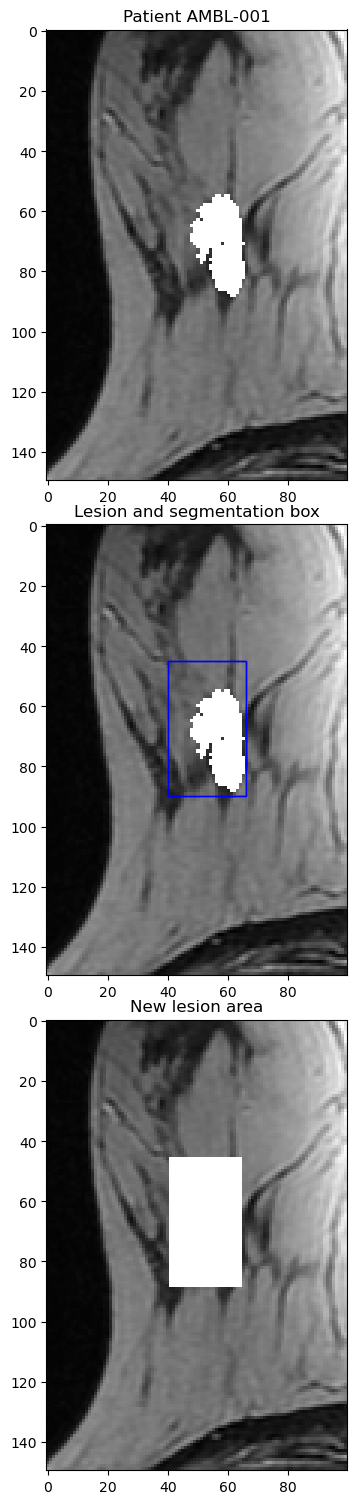

In [82]:
crop_x_min, crop_x_max = 100,200
crop_y_min, crop_y_max = 125,275
z = 82

# cropping the volumes to the zoom area
cropped_volume = volume[z, crop_y_min:crop_y_max, crop_x_min:crop_x_max]
cropped_mask = mask[z, crop_y_min:crop_y_max, crop_x_min:crop_x_max]
cropped_bounded_mask = bounded_mask[z, crop_y_min:crop_y_max, crop_x_min:crop_x_max]

fig, ax = plt.subplots(3, 1, figsize=(15, 15))
fig.tight_layout()

ax[0].imshow(cropped_volume, cmap=plt.cm.gray)
ax[0].imshow(cropped_mask, alpha=(cropped_mask != 0).astype(float), cmap=plt.cm.gray)
ax[0].set_title(f"Patient {patient_id}")

ax[1].imshow(cropped_volume, cmap=plt.cm.gray)
ax[1].imshow(cropped_mask, alpha=(cropped_mask != 0).astype(float), cmap=plt.cm.gray)
show_box(np.array([x_min-crop_x_min-1, y_min-crop_y_min-1, x_max-crop_x_min+1, y_max-crop_y_min+1]), ax[1])
ax[1].set_title("Lesion and segmentation box")

ax[2].imshow(cropped_volume, cmap=plt.cm.gray)
ax[2].imshow(cropped_bounded_mask, alpha=(cropped_bounded_mask != 0).astype(float), cmap=plt.cm.gray)
show_box(np.array([x_min-crop_x_min-1, y_min-crop_y_min-1, x_max-crop_x_min+1, y_max-crop_y_min+1]), ax[1])
ax[2].set_title("New lesion area")

plt.show()

## Creation of the dataset

In [84]:
features = shape_features + first_order_featues + glcm_features + gldm_features + glrlm_features + glszm_features + ngtdm_features

In [90]:
def get_ramifications_dataset(df):
    """
    Given the lesions dataframe, iterate over each lesion
    """
    for _, row in df.iterrows(): # iterate over all lesions
        patient_id = row["Patient ID"]

        # get patient data
        label = row["tumor/benign"]
        volume_3d = np.load(row["RobustScaled Registered Ax T2 FSE path"])
        pixel_spacing = row["Pixel Spacing"]
        slice_thickness = row["Slice Thickness"]
        roi = np.load(row["Cleaned Roi mask Filepath"])

        zmin, zmax, ymin, ymax, xmin, xmax = bbox_3D(roi)
        bounded_mask = np.zeros(volume_3d.shape)
        bounded_mask[z_min:z_max, y_min:y_max, x_min:x_max] = 1

        extractor = featureextractor.RadiomicsFeatureExtractor()

        # create the SITK image of the MRI
        sitk_img = sitk.GetImageFromArray(volume_3d)
        sitk_img.SetSpacing( (pixel_spacing, pixel_spacing, slice_thickness) )

        # create the SITK image of the lesion mask
        sitk_mask = sitk.GetImageFromArray(bounded_mask)
        sitk_mask.SetSpacing( (pixel_spacing,pixel_spacing, slice_thickness) )

        # extract the radiomic features
        try:
            extracted_features = extractor.execute(sitk_img, sitk_mask)
        except ValueError as e:
            print(f"[{patient_id}] Skipping error: {e}")
            continue

        # return the features plus the label and the patient id
        l = [ 
            value.item() 
            for key, value in extracted_features.items() if key in features
        ]
        l.insert(0, label)
        l.insert(0, patient_id)
        yield l

In [92]:
iterator = get_ramifications_dataset(df)
ramifications_df = pd.DataFrame(
    iterator,
    columns = ["Patient id", "tumor/benign"] + features
)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [93]:
ramifications_df.to_csv("/media/bendico765/Crucial X9/MRI Lesions/ramifications.csv")

## XGBoost Nested Cross-Validation on all the features

In [292]:
features = shape_features + first_order_featues + glcm_features + gldm_features + glrlm_features + glszm_features + ngtdm_features

ramifications_df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/ramifications.csv", index_col=0)
ramifications_df.info()

X = ramifications_df[features].values
y = ramifications_df["tumor/benign"].values

# take 20 samples (10 benign and 10 tumor) as a final test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 20, stratify = y, random_state = 0)

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 0 to 163
Columns: 107 entries, Patient id to original_ngtdm_Strength
dtypes: float64(106), object(1)
memory usage: 138.4+ KB


#### 5-FOLD WITH GRID SEARCH ####
Fold 0 - Roc Auc score 0.5333333333333333 Accuracy 0.5517241379310345
Fold 1 - Roc Auc score 0.6357142857142858 Accuracy 0.5862068965517241
Fold 2 - Roc Auc score 0.6238095238095238 Accuracy 0.5862068965517241
Fold 3 - Roc Auc score 0.7047619047619047 Accuracy 0.5862068965517241
Fold 4 - Roc Auc score 0.5459183673469388 Accuracy 0.5714285714285714

#### HOLD-OUT TEST ####
Model #0 - Auc score: 0.545
Model #1 - Auc score: 0.485
Model #2 - Auc score: 0.485
Model #3 - Auc score: 0.585
Model #4 - Auc score: 0.495
Mean: 0.519 std: 0.0397994974842648

### AGGREGATED CLASSIFIER PERFORMANCES ###
              precision    recall  f1-score   support

         0.0       0.46      0.60      0.52        10
         1.0       0.43      0.30      0.35        10

    accuracy                           0.45        20
   macro avg       0.45      0.45      0.44        20
weighted avg       0.45      0.45      0.44        20



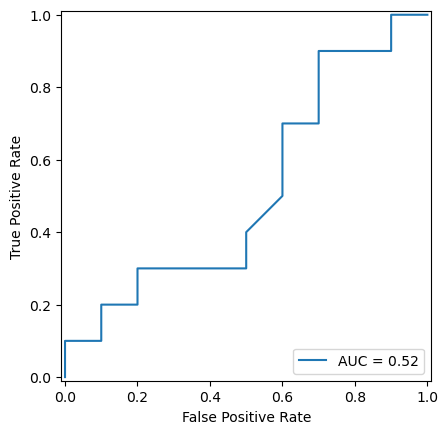

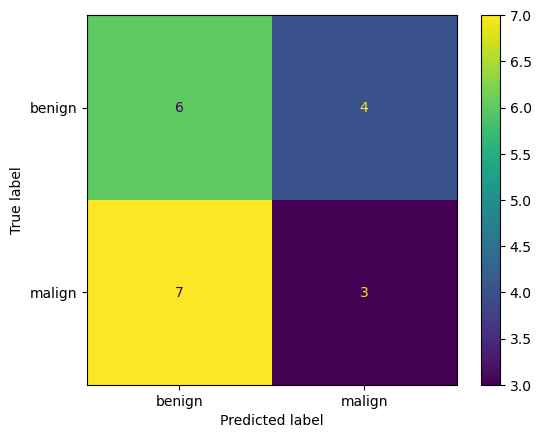

"\n# XGBoost internal representation does not have feature names\n# need to set them manually\nclf.get_booster().feature_names = features\n\nfeature_importance =clf.get_booster().get_score(importance_type='gain')\n{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}\n"

In [293]:
cv_grid = {
    "n_estimators": [10, 20, 50, 100, 200, 500],
    "max_depth": [3, 5, 10, None],
    "grow_policy": ["depthwise", "lossguide"],
}
N_OUTER_FOLDS = 5
N_INNER_FOLDS = 5
outer_fold = StratifiedKFold(n_splits=N_OUTER_FOLDS, shuffle=True, random_state=0)
clfs = []
scores = []

####### K-FOLD WITH GRID SEARCH TO GET K MODELS ######
print(f"#### {N_OUTER_FOLDS}-FOLD WITH GRID SEARCH ####")
for i, (train_index, test_index) in enumerate(outer_fold.split(X_train, y_train)): # outer fold  
    # inner fold for grid search
    grid_search = GridSearchCV(
        estimator=xgb.XGBClassifier(eval_metric=metrics.roc_auc_score),
        param_grid=cv_grid,
        cv=N_INNER_FOLDS,
        scoring="roc_auc",
        refit=True,
        verbose=0,
        n_jobs=-1
    )
    # fitting on the fold training data
    grid_search.fit(X_train[train_index], y_train[train_index])

    # getting the best estimator (already refitted on the train data)
    best_estimator = grid_search.best_estimator_
    
    # assessing the performances on the k-th fold
    y_predicted = best_estimator.predict_proba(X_train[test_index])
    auc_score = metrics.roc_auc_score(y_train[test_index], y_predicted[:,1])
    accuracy_score = metrics.accuracy_score(y_train[test_index], np.argmax(y_predicted, axis=1))
    scores.append(auc_score)
    
    print(f"Fold {i} - Roc Auc score {auc_score} Accuracy {accuracy_score}")
    clfs.append(best_estimator)

##### ESTIMATING THE AGGREGATED K MODELS PERFORMANCES ON THE HOLD-OUT #####
print(f"\n#### HOLD-OUT TEST ####")
# testing each model on hold out
y_predicted = [ clf.predict_proba(X_test) for clf in clfs ]    

# measuring the scores of the single classifiers
auc_scores = [
    metrics.roc_auc_score(y_test, y_pred[:,1])
    for y_pred in y_predicted
]
for i, auc_score in enumerate(auc_scores):
    print(f"Model #{i} - Auc score: {auc_score}")
    
aggregated_mean = np.mean(auc_scores)
aggregated_std = np.std(auc_scores)
print(f"Mean: {aggregated_mean} std: {aggregated_std}")

# computing the aggregated mean on each single prediction
aggregated_prediction = np.mean(y_predicted, axis=0)

# getting auc and confusion matrix for the overall classifier
print(f"\n### AGGREGATED CLASSIFIER PERFORMANCES ###")
show_model_performances(y_test, aggregated_prediction) 

"""
# XGBoost internal representation does not have feature names
# need to set them manually
clf.get_booster().feature_names = features

feature_importance =clf.get_booster().get_score(importance_type='gain')
{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
"""

# Pyradiomics on MEDSAM segmentations (AX T2 FSE)

## MEDSAM Model

In [47]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

In [48]:
def get_medsam_seg(medsam_model, img_slice, seg_box):
    size = 1024
    img_3c = np.repeat(img_slice[:,:,None],3, axis=-1) # ( H, W, 3 )
    H, W, _ = img_3c.shape

    # resize to size x size
    img = transform.resize(img_3c, (size, size), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img = (img - img.min()) / np.clip(
        img.max() - img.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)

    # convert the shape to (3, H, W)
    img_tensor = torch.tensor(img).float().permute(2, 0, 1).unsqueeze(0).to(device) # (1,3,size,size)

    # transfer seg_box to sizexsize scale
    box = seg_box / np.array([W, H, W, H]) * size
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_tensor) # (1, 256, 64, 64)
    
    return medsam_inference(medsam_model, image_embedding, box, H, W)

In [49]:
MedSAM_CKPT_PATH = "sam_vit_b_01ec64.pth"
device = "cpu"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

/home/bendico765/anaconda3/envs/tesi/lib/python3.9/site-packages/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, 

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


## Example with MEDSAM

In [116]:
df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv", index_col=0)

In [117]:
patient = df.iloc()[0]
patient_id = patient["Patient ID"]
volume = np.load(patient["RobustScaled Registered Ax T2 FSE path"])
mask = np.load(patient["Cleaned Roi mask Filepath"])
z_min, z_max, y_min, y_max, x_min, x_max = bbox_3D(mask)

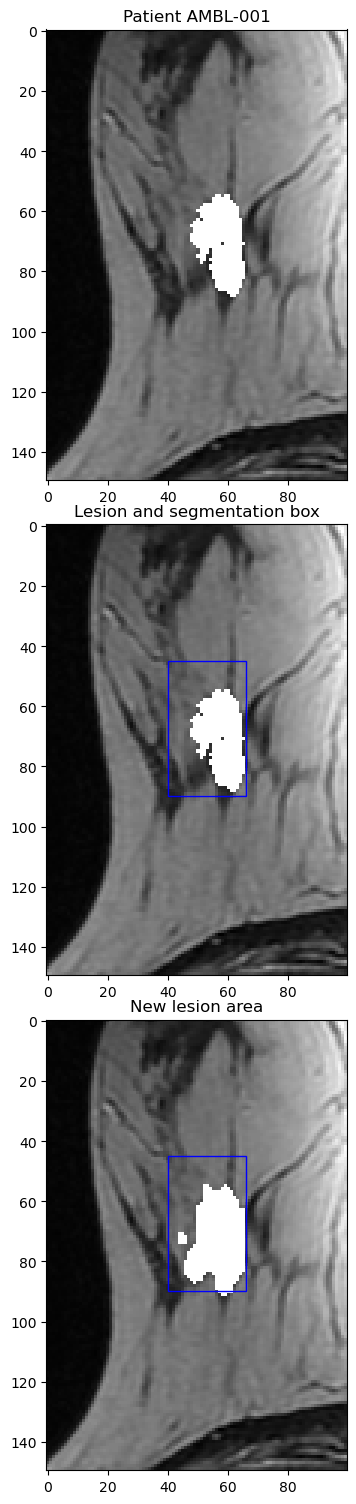

In [124]:
crop_x_min, crop_x_max = 100,200
crop_y_min, crop_y_max = 125,275
z = 82

# computing the segmentation box for medsam
seg_box = np.array([[
    x_min, # x_0
    y_min, # y_0
    x_max, # x_1
    y_max  # y_1
]])

cropped_box = np.array([
    x_min-crop_x_min-1, 
    y_min-crop_y_min-1, 
    x_max-crop_x_min+1, 
    y_max-crop_y_min+1]
)

# cropping the volumes to the zoom area
cropped_volume = volume[z, crop_y_min:crop_y_max, crop_x_min:crop_x_max]
cropped_mask = mask[z, crop_y_min:crop_y_max, crop_x_min:crop_x_max]

# compute medsam segmentation
medsam_seg = get_medsam_seg(medsam_model, volume[z], seg_box)

fig, ax = plt.subplots(3, 1, figsize=(15, 15))
fig.tight_layout()

ax[0].imshow(cropped_volume, cmap=plt.cm.gray)
ax[0].imshow(cropped_mask, alpha=(cropped_mask != 0).astype(float), cmap=plt.cm.gray)
ax[0].set_title(f"Patient {patient_id}")

ax[1].imshow(cropped_volume, cmap=plt.cm.gray)
ax[1].imshow(cropped_mask, alpha=(cropped_mask != 0).astype(float), cmap=plt.cm.gray)
show_box(cropped_box, ax[1])
ax[1].set_title("Lesion and segmentation box")

ax[2].imshow(cropped_volume, cmap=plt.cm.gray)
ax[2].imshow(
    medsam_seg[crop_y_min:crop_y_max, crop_x_min:crop_x_max], 
    alpha=(medsam_seg[crop_y_min:crop_y_max, crop_x_min:crop_x_max] != 0).astype(float), 
    cmap=plt.cm.gray
)
show_box(cropped_box, ax[2])
ax[2].set_title("New lesion area")

plt.show()

## Creation of the dataset

In [125]:
features = shape_features + first_order_featues + glcm_features + gldm_features + glrlm_features + glszm_features + ngtdm_features

In [126]:
def get_medsam_dataset(df):
    """
    Given the lesions dataframe, iterate over each lesion
    """
    for _, row in df.iterrows(): # iterate over all lesions
        patient_id = row["Patient ID"]

        # get patient data
        label = row["tumor/benign"]
        volume_3d = np.load(row["RobustScaled Registered Ax T2 FSE path"])
        pixel_spacing = row["Pixel Spacing"]
        slice_thickness = row["Slice Thickness"]
        roi = np.load(row["Cleaned Roi mask Filepath"])

        zmin, zmax, ymin, ymax, xmin, xmax = bbox_3D(roi)
        # computing the segmentation box for medsam
        seg_box = np.array([[
            x_min, # x_0
            y_min, # y_0
            x_max, # x_1
            y_max  # y_1
        ]])
        # compute medsam segmentation for each slice
        #medsam_seg = get_medsam_seg(medsam_model, volume_3d[z], seg_box)
        mask = np.zeros(volume_3d.shape)
        for z in range(zmin, zmax+1):
            mask[z] = get_medsam_seg(medsam_model, volume_3d[z], seg_box)

        extractor = featureextractor.RadiomicsFeatureExtractor()

        # create the SITK image of the MRI
        sitk_img = sitk.GetImageFromArray(volume_3d)
        sitk_img.SetSpacing( (pixel_spacing, pixel_spacing, slice_thickness) )

        # create the SITK image of the lesion mask
        sitk_mask = sitk.GetImageFromArray(mask)
        sitk_mask.SetSpacing( (pixel_spacing,pixel_spacing, slice_thickness) )

        # extract the radiomic features
        try:
            extracted_features = extractor.execute(sitk_img, sitk_mask)
        except ValueError as e:
            print(f"[{patient_id}] Skipping error: {e}")
            continue

        # return the features plus the label and the patient id
        l = [ 
            value.item() 
            for key, value in extracted_features.items() if key in features
        ]
        l.insert(0, label)
        l.insert(0, patient_id)
        yield l

In [128]:
iterator = get_ramifications_dataset(df)
medsam_df = pd.DataFrame(
    iterator,
    columns = ["Patient id", "tumor/benign"] + features
)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [129]:
medsam_df.to_csv("/media/bendico765/Crucial X9/MRI Lesions/medsam.csv")

## XGBoost Nested Cross-Validation on all the features

In [294]:
features = shape_features + first_order_featues + glcm_features + gldm_features + glrlm_features + glszm_features + ngtdm_features

medsam_df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/medsam.csv", index_col=0)
medsam_df.info()

X = medsam_df[features].values
y = medsam_df["tumor/benign"].values

# take 20 samples (10 benign and 10 tumor) as a final test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 20, stratify = y, random_state = 0)

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 0 to 163
Columns: 107 entries, Patient id to original_ngtdm_Strength
dtypes: float64(106), object(1)
memory usage: 138.4+ KB


#### 5-FOLD WITH GRID SEARCH ####
Fold 0 - Roc Auc score 0.5333333333333333 Accuracy 0.5517241379310345
Fold 1 - Roc Auc score 0.6357142857142858 Accuracy 0.5862068965517241
Fold 2 - Roc Auc score 0.6238095238095238 Accuracy 0.5862068965517241
Fold 3 - Roc Auc score 0.7047619047619047 Accuracy 0.5862068965517241
Fold 4 - Roc Auc score 0.5459183673469388 Accuracy 0.5714285714285714

#### HOLD-OUT TEST ####
Model #0 - Auc score: 0.545
Model #1 - Auc score: 0.485
Model #2 - Auc score: 0.485
Model #3 - Auc score: 0.585
Model #4 - Auc score: 0.495
Mean: 0.519 std: 0.0397994974842648

### AGGREGATED CLASSIFIER PERFORMANCES ###
              precision    recall  f1-score   support

         0.0       0.46      0.60      0.52        10
         1.0       0.43      0.30      0.35        10

    accuracy                           0.45        20
   macro avg       0.45      0.45      0.44        20
weighted avg       0.45      0.45      0.44        20



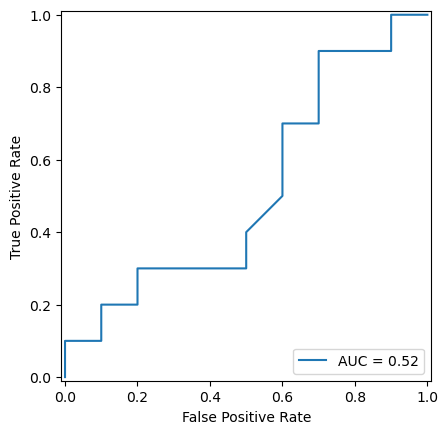

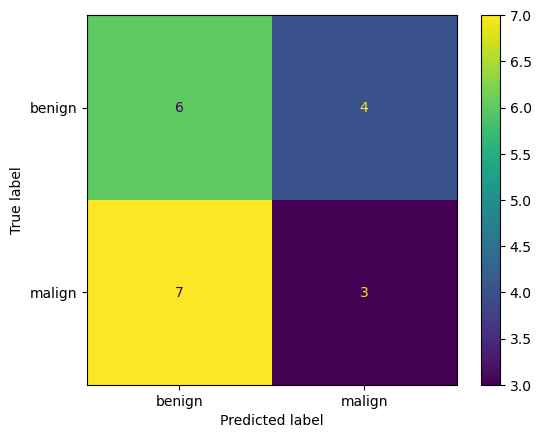

"\n# XGBoost internal representation does not have feature names\n# need to set them manually\nclf.get_booster().feature_names = features\n\nfeature_importance =clf.get_booster().get_score(importance_type='gain')\n{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}\n"

In [295]:
cv_grid = {
    "n_estimators": [10, 20, 50, 100, 200, 500],
    "max_depth": [3, 5, 10, None],
    "grow_policy": ["depthwise", "lossguide"],
}
N_OUTER_FOLDS = 5
N_INNER_FOLDS = 5
outer_fold = StratifiedKFold(n_splits=N_OUTER_FOLDS, shuffle=True, random_state=0)
clfs = []
scores = []

####### K-FOLD WITH GRID SEARCH TO GET K MODELS ######
print(f"#### {N_OUTER_FOLDS}-FOLD WITH GRID SEARCH ####")
for i, (train_index, test_index) in enumerate(outer_fold.split(X_train, y_train)): # outer fold  
    # inner fold for grid search
    grid_search = GridSearchCV(
        estimator=xgb.XGBClassifier(eval_metric=metrics.roc_auc_score),
        param_grid=cv_grid,
        cv=N_INNER_FOLDS,
        scoring="roc_auc",
        refit=True,
        verbose=0,
        n_jobs=-1
    )
    # fitting on the fold training data
    grid_search.fit(X_train[train_index], y_train[train_index])

    # getting the best estimator (already refitted on the train data)
    best_estimator = grid_search.best_estimator_
    
    # assessing the performances on the k-th fold
    y_predicted = best_estimator.predict_proba(X_train[test_index])
    auc_score = metrics.roc_auc_score(y_train[test_index], y_predicted[:,1])
    accuracy_score = metrics.accuracy_score(y_train[test_index], np.argmax(y_predicted, axis=1))
    scores.append(auc_score)
    
    print(f"Fold {i} - Roc Auc score {auc_score} Accuracy {accuracy_score}")
    clfs.append(best_estimator)

##### ESTIMATING THE AGGREGATED K MODELS PERFORMANCES ON THE HOLD-OUT #####
print(f"\n#### HOLD-OUT TEST ####")
# testing each model on hold out
y_predicted = [ clf.predict_proba(X_test) for clf in clfs ]    

# measuring the scores of the single classifiers
auc_scores = [
    metrics.roc_auc_score(y_test, y_pred[:,1])
    for y_pred in y_predicted
]
for i, auc_score in enumerate(auc_scores):
    print(f"Model #{i} - Auc score: {auc_score}")
    
aggregated_mean = np.mean(auc_scores)
aggregated_std = np.std(auc_scores)
print(f"Mean: {aggregated_mean} std: {aggregated_std}")

# computing the aggregated mean on each single prediction
aggregated_prediction = np.mean(y_predicted, axis=0)

# getting auc and confusion matrix for the overall classifier
print(f"\n### AGGREGATED CLASSIFIER PERFORMANCES ###")
show_model_performances(y_test, aggregated_prediction) 

"""
# XGBoost internal representation does not have feature names
# need to set them manually
clf.get_booster().feature_names = features

feature_importance =clf.get_booster().get_score(importance_type='gain')
{k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
"""